# Tekst analyse van Tweede Kamer moties
> Wie zet wat op de agenda?

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/moties_glass.png
- categories: []

![](moties/wordcloud.png)

Nog net voor de verkiezingen deel 2 van het motie-onderzoek! Naast deze blog heb ik ook nog [de StemVinder](https://stemvinder.ew.r.appspot.com/) ontwikkeld om snel relevante moties te vinden. 

In dit deel kijk ik naar de inhoud van de moties. Op de moties te clusteren naar onderwerp gebruikte ik in eerste instantie een bekende techniek [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), maar via een gelukkig toeval kwam ik achter een gloednieuwe aanpak die veel beter werkt! Longhow Lam heeft deze toegepast op [kamerdebatten](https://www.linkedin.com/posts/longhowlam_top2vec-stem-helper-activity-6772061735844098048-zKd6) van de Tweede Kamer. 

Het [Top2Vec](https://github.com/ddangelov/Top2Vec) algoritme probeert soortgelijke woorden en documenten te clusteren en hieruit onderwerpen te destilleren. In de wordcloud hierboven staan heel generieke woorden die in veel moties voorkomen. Deze zijn niet onderscheidend en worden er automatisch uitgefilterd door het algoritme. Echt weer zo'n voorbeeld van een doorbraak in machine learning die sneller en beter werkt waardoor oude technieken bij het grofvuil kunnen. 

Bij de moties worden er ongeveer 250 topics geïdentificeerd. In deze onderwerpen zit wat overlap en het is een beetje lastig visualiseren, dus uiteindelijk heb ik die voor deze blogpost samengevoegd tot 15. Onderop deze blog staan wordclouds van de 15 onderwerpen.

In [1]:
# hide
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import math
import altair as alt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:
# hide
DATA_DIR = Path('data')
def load(filename):
    f = open(DATA_DIR/filename,"rb")
    return pickle.load(f)
    
def save(data, filename):
    with open(DATA_DIR/filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

party_colors = {
  'CDA':'#5cb957',
  'ChristenUnie':'#00a5e8',
  'D66':'#04a438',
  'GroenLinks':'#48a641',
  'PVV':'#002759',
  'PvdA':'#df111a',
  'PvdD':'#006b2d',
  'SGP':'#d86120',
  'SP':'#e3001b',
  'VVD':'#ff7f0e',
  'DENK':'#17becf',
  'FVD':'#800000',
  'Groep Krol/vKA':'pink',
  '50PLUS':'#93117e'}

parties = ['VVD',
 'CDA',
 'ChristenUnie',
 'D66',
 'SGP',
 'FVD',
 '50PLUS',
 'PVV',
 'PvdA',
 'DENK',
 'GroenLinks',
 'SP',
 'PvdD']

In [3]:
# hide
def get_stem_column(largest):
    return [c for c in df.columns if 'Stem_' in c and c != 'Stem_persoon' and c[5:] in largest]

def postprocess_chart(chart, hw=(200,300)):
    chart = chart.configure_axis(
        grid=False).configure_view(
        strokeWidth=0)
    if hw:
        chart.properties(width=hw[1], height=hw[0])
    return chart

def normalize(df, field, on='Aantal'):
    sums = df.groupby(field)[on].transform('sum')
    df[on] = df[on].div(sums)
    return df

def rankify(df, field, on='Aantal'):
    df['Rank'] = df.groupby(field)[on].rank("dense", ascending=False)
    df.loc[df['Rank'] > 4, 'Rank'] = ''
    return df



## Welk soort onderwerpen staan op de agenda?
Eerst kijken we naar de ontwikkeling van de onderwerpen van de ingediende moties. We weten al dat het absoluut aantal moties stijgt, dus heb ik gekeken naar de relatieve verdeling van de onderwerpen.

In [5]:
# hide_input
# df.groupby(['Jaar', 'Topic']).size().unstack(fill_value=0)
source = df.groupby(['Kamer', 'Topic']).size().reset_index(name='Aantal moties')

# Overview of topic distribution over all years
chart = alt.Chart(source).mark_bar().encode(
    x='Kamer:O',
    y=alt.Y('Aantal moties:Q', stack='normalize',axis=alt.Axis(format='%')),
    color=alt.Color('Topic:N'),
    # sort=alt.EncodingSortField('Aantal moties', order='descending'))
    # order=alt.Order('Aantal moties:Q',sort='descending')
    tooltip = 'Topic'
)
postprocess_chart(chart, (200,250))

alt.Chart(...)

Opvallend dat de verhoudingen redelijk stabiel zijn! Je ziet dat in de loop van de tijd klimaat en energie, milieu en regelgeving (heel veel coronaregels zitten hier ook in gecategoriseerd), sociale zaken en wonen omhoog gaan. Omlaag gaan landbouw en dierenwelzijn, natuur en gaswinning, onderwijs en openbaar vervoer. Binnen de onderwerpen zijn natuurlijk wel verschuivingen waar het precies over gaat. We onderzoeken nu de ingediende moties tijdens de afgelopen Tweede Kamer periode.

## Meest actieve partijen per onderwerp
We onderzoeken welke partijen het meest actief zijn door op drie manieren naar de data te kijken:

1. Aantal ingediende moties (per partij per onderwerp)
2. Aantal succesvolle moties
3. Aantal succesvolle moties per zetel

In [8]:
# hide_input
source = df[(df['Kamer'] == 'Rutte III') & (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
source = rankify(source, 'Topic')
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    color=alt.Color("Aantal:Q", 
                      scale = alt.Scale(scheme="greens")),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

In bovenstaande grafiek zien we bijvoorbeeld dat op onderwijs de meeste moties worden ingediend door Groenlinks (1 in de grafiek), gevolgd door de SP (2), PvdA (3) en D66 (4). Een punt van aandacht is dat deze analyse niet aangeeft wat de partijen met de moties willen bereiken, bijvoorbeeld op openbaar vervoer wil VVD waarschijnlijk heel iets anders bereiken dan SP.

PVV is erg actief op justitie, en de PvdD op klimaat, dierenwelzijn milieu en natuur. Ook de enorme output van de SP valt op! Maar ingediend is niet hetzelfde als aangenomen, dat wordt de volgende grafiek:

In [9]:
# hide_input
source = df[(df['Kamer'] == 'Rutte III') & (df['BesluitSoort'] == 1)& (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Aantal')
source = rankify(source, 'Topic')
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    color=alt.Color("Aantal:Q", 
                      scale = alt.Scale(scheme="greens")),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Wat betreft het aantal succesvolle moties dan zien we daar ineens vier partijen bovendrijven: CDA, D66, GroenLinks en de VVD. Veel regeringspartijen, dat is logisch want die hebben een meerderheid. Ook vind ik het opvallend dat PvdA echt op sociale zaken en het pensioenstelsel succesvol is en GroenLinks op de andere onderwerpen. 

Nu kijken we naar het aantal succesvolle moties **per zetel**

In [10]:
# hide
aantal_moties = df.groupby(['Kamer','Indienende_partij', 'Topic']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij','Topic']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in parties]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(max_votes_per_party).merge(aantal_succesvol)

stats['aantal_zetel'] = stats['aantal'] /stats['num_votes']
stats['aantal_succesvol_zetel'] = stats['aantal_succesvol'] /stats['num_votes']
stats.head()

,Kamer,Indienende_partij,Topic,aantal,num_votes,aantal_succesvol,aantal_zetel,aantal_succesvol_zetel
0,Balkenende IV,CDA,Algemene zaken,33,41.0,30,0.804878,0.731707
1,Balkenende IV,CDA,Buitenlandse zaken,21,41.0,21,0.512195,0.512195
2,Balkenende IV,CDA,Europese Unie,4,41.0,3,0.097561,0.073171
3,Balkenende IV,CDA,Financiele sector,19,41.0,18,0.463415,0.439024
4,Balkenende IV,CDA,Justitie,20,41.0,15,0.487805,0.365854


In [11]:
# hide_input
source = stats[stats['Kamer']=='Rutte III'].reset_index()
source = rankify(source, 'Topic', on='aantal_succesvol_zetel')
base = alt.Chart(source)

chart = base.mark_rect().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    color=alt.Color("aantal_succesvol_zetel:Q", 
                      scale = alt.Scale(scheme="greens"))
)

text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Met je stem koop je op 17 maart politieke invloed. Dit overzicht geeft weer hoeveel 'waar je voor je geld' krijgt, hoeveel succesvolle moties een zetel van een partij er doorheen krijgt per onderwerp. Het is weer een heel ander beeld: de christelijke partijen doen het heel erg goed (even gecheckt en inderdaad het Dik-Faber effect bij de ChristenUnie op Zorg, Voordewind op Buitenlandse zaken) en de SP komt een stuk minder terug. Opvallend ook dat D66 relatief weinig scoort op Onderwijs. Partijen die minder in de prijzen vallen zijn FvD (nr 5 op Europese Unie), de PVV nergens en de VVD op financiele sector (nr 5). Bij de VVD is dit te verklaren doordat ze veel zetels bekleedt.

In [12]:
# hide
df[(df['Indienende_partij']=='PvdA') & (df['Kamer'] == 'Rutte III') & (df['BesluitSoort'] == 1) & (df['Topic'] == 'Sociale zaken')]['Indiener_persoon'].value_counts()

G.J. (Gijs) van Dijk    38
L.F. Asscher            17
W.J. Moorlag            11
J.W.M. Kerstens          9
K.A.E. van den Hul       6
H. Nijboer               4
A.H. Kuiken              4
Name: Indiener_persoon, dtype: int64

## Waar richten de partijen zich op?
In bovenstaande grafieken hebben we de partijen onderling vergeleken. Nu kijken we **per partij** op welk vlak ze het meest actief zijn

In [13]:
# hide
#normalized version
source = df[(df['Kamer'] == 'Rutte III') & (df['Indienende_partij'].isin(parties))]
source = source.groupby(['Indienende_partij','Topic']).size().reset_index(name='Percentage')
source = normalize(source, 'Indienende_partij', on='Percentage')
source = rankify(source, 'Indienende_partij', on='Percentage')

In [14]:
# hide_input
base = alt.Chart(source)
chart = base.mark_circle().encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    size=alt.Size('Percentage:Q', scale=alt.Scale(range=[0,500])),
    color=alt.Color("Indienende_partij", 
                      scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties])),
)

text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('Topic:N'),
    alt.Y('Indienende_partij:N'),
    alt.Text('Rank:N'))

chart + text

alt.LayerChart(...)

Als een partij een aantal heel grote bollen heeft betekent dit dat de partij zich heel erg richt op dit onderwerp. Zijn er geen grote bollen binnen een partij is de inzet meer over de onderwerpen verspreid.
Algemene zaken, Onderwijs en Zorg krijgen bij veel partijen veel aandacht. Daarnaast hebben FvD, PVV, 50PLUS en de PvdD een heel uitgesproken profiel. In het [achterliggende notebook](https://colab.research.google.com/github/jvanelteren/blog/blob/master/_notebooks/2021-03-10-kamermoties_topics.ipynb) heb ik ook nog gekeken naar de ontwikkelingen per partij van de afgelopen 4 kamerperiodes.

In [15]:
# hide
aantal_moties = df.groupby(['Kamer','Indienende_partij', 'Topic']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij','Topic']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in parties]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(max_votes_per_party).merge(aantal_succesvol)

stats['aantal_zetel'] = stats['aantal'] /stats['num_votes']
stats['aantal_succesvol_zetel'] = stats['aantal_succesvol'] /stats['num_votes']
stats.head()

,Kamer,Indienende_partij,Topic,aantal,num_votes,aantal_succesvol,aantal_zetel,aantal_succesvol_zetel
0,Balkenende IV,CDA,Algemene zaken,33,41.0,30,0.804878,0.731707
1,Balkenende IV,CDA,Buitenlandse zaken,21,41.0,21,0.512195,0.512195
2,Balkenende IV,CDA,Europese Unie,4,41.0,3,0.097561,0.073171
3,Balkenende IV,CDA,Financiele sector,19,41.0,18,0.463415,0.439024
4,Balkenende IV,CDA,Justitie,20,41.0,15,0.487805,0.365854


# hide
## Ontwikkeling per partij

In [16]:
# hide
# this is not normalized yet!

def get_party_chart(source, partij, axis=True):
    source = source.groupby(['Kamer', 'Topic']).size().reset_index(name='Aantal moties')
    source = normalize(source, field='Kamer', on='Aantal moties')
    source = rankify(source, field='Kamer', on='Aantal moties')

    # Overview of topic distribution over all years
    import altair as alt
    if axis:
        chart = alt.Chart(source).mark_rect().encode(
        y=alt.Y('Topic:N'),
        x=alt.X('Kamer:O',axis=alt.Axis(title=partij)),
        color = alt.Color('Aantal moties:Q',scale = alt.Scale(scheme="greens"), legend=None),
        tooltip = 'Topic')
    else:
        chart = alt.Chart(source).mark_rect().encode(
        y=alt.Y('Topic:N', axis=None),
        x=alt.X('Kamer:O',axis=alt.Axis(title=partij)),
        color = alt.Color('Aantal moties:Q',scale = alt.Scale(scheme="greens"), legend=None),
        tooltip = 'Topic')
    text = alt.Chart(source).mark_text().encode(
        y=alt.Y('Topic:N'),
        x='Kamer:O',
        text=alt.Text('Rank:N'))
    return chart + text

legend = [False] * len(parties)
legend[0] = True
charts = [get_party_chart(df[df['Indienende_partij'] == partij], partij, legend[i]) for i, partij in enumerate(parties)]



In [17]:
# hide
import altair as alt
alt.hconcat(*charts)

alt.HConcatChart(...)

## Stemgedrag per onderwerp
Dan toch nog eens proberen het stemgedrag te visualiseren. Als de VVD iets indient voor de Financiele Sector betekent dit namelijk iets heel anders dan als de SP dat doet. In onderstaande plots staat per onderwerp het stemgedrag gevisualiseerd. Positief of negatief zegt niets, het gaat om partijen die dichtbij of ver weg van elkaar staan. PvdD en VVD vormen meestal de uitersten en verschillen dus het meeste op stemgedrag. Deze grafieken verklaren meestal zo'n 35%-55% van de variatie in het stemgedrag. Let op: het is dus een versimpeling van de werkelijkheid!

In [18]:
# hide

    
def get_pca(df, n_components=1, num_largest=None, return_ratio=False):
    largest = parties
    stem_column = get_stem_column(largest)
    source_year = df[stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent').fit_transform(source_year)
    pca = PCA(n_components = n_components)
    pca = pca.fit(X_year)
    print('explained variance by factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
    res_year = pca.transform(X_year)
    source = pd.DataFrame(res_year)
    source['partij'] = source_year.T.columns.str[5:]
    source = source.rename(index=str, columns={0: "x", 1: "y"}).sort_values('x',ascending=False)
    return (source, pca.explained_variance_ratio_) if return_ratio else source

In [19]:
# hide

size=800
def pca_topic(df, topic, kamer, twodim=False):
    column_list = df.columns
    source = df[(df['Topic'] == topic) & (df['Kamer'] == kamer)]
    num_moties = len(source)
    if twodim:
        source, explained_variance_ratio_ = get_pca(source, n_components = 2, return_ratio=True)
    else:
        source, explained_variance_ratio_ = get_pca(source, n_components = 1, return_ratio=True)
    mid = (source['x'].max() + source['x'].min())/2
    median = source['x'].median()
    if source[source['partij'] =='VVD']['x'].values > median: # make sure that VVD is on the right part of the x-axis
        source['x'] += 2 * (mid - source['x'])
    if twodim:
        points = alt.Chart(source,width= size * explained_variance_ratio_[0],height = size * explained_variance_ratio_[1]).mark_point().encode(
        # x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
        # y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
        x=alt.X('x:Q', axis=None),
        y=alt.Y('y:Q', axis=None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
        tooltip=['partij:N']
        )

        text = points.mark_text(
            align='left',
            baseline='middle',
            dx=np.random.uniform(0,10),
            dy=np.random.uniform(0,10)
            # opacity=0.5
        ).encode(
            text='partij:N'
        ).properties(
            title='Welke partijen lijken op elkaar'
        )

        return (points + text).configure_axis(
            grid=False).configure_view(
            strokeWidth=1)
        
    else:
        chart = alt.Chart(source,width=200,height = 50).mark_bar().encode(
        x=alt.X('partij:N',sort=alt.SortField(field="x", order='descending')),
        y=alt.Y('x:Q', axis = None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
    )
        chart.encoding.x.title = f'{topic} #{num_moties} {round(explained_variance_ratio_[0]*100)}%'
        
        return chart



In [20]:
# hide
topics = df[df['Kamer']=='Rutte III'].groupby('Topic').size().sort_values(ascending=False).index
for topic in topics:
    print(topic, end=' ')
    pca_topic(df, topic, 'Rutte III', twodim=True)

Zorg explained variance by factors [0.51892989 0.13430655] 0.6532364439859102
Onderwijs explained variance by factors [0.42219798 0.18218039] 0.6043783639586945
Sociale zaken explained variance by factors [0.46489449 0.20908818] 0.6739826760165024
Algemene zaken explained variance by factors [0.35376299 0.20804076] 0.561803754236881
Buitenlandse zaken explained variance by factors [0.4226423 0.2044308] 0.6270730923727308
Natuur & gaswinning explained variance by factors [0.45642703 0.18303284] 0.639459865514515
Klimaat & energie explained variance by factors [0.4318377  0.24471266] 0.6765503566794684
Justitie explained variance by factors [0.308517   0.27659453] 0.5851115249649784
Landbouw & dierenwelzijn explained variance by factors [0.47284611 0.16184021] 0.6346863231121765
Milieu & regelgeving explained variance by factors [0.43750559 0.18748599] 0.6249915779850153
Pensioenstelsel explained variance by factors [0.4480875  0.21902256] 0.6671100607228834
Europese Unie explained varia

In [21]:
# hide
charts = [pca_topic(df, topic, 'Rutte III') for topic in topics]

explained variance by factors [0.51892989] 0.5189298897780621
explained variance by factors [0.42219798] 0.4221979764700438
explained variance by factors [0.46489449] 0.4648944932269601
explained variance by factors [0.35376299] 0.3537629943335133
explained variance by factors [0.4226423] 0.4226422971125906
explained variance by factors [0.45642703] 0.4564270265122179
explained variance by factors [0.4318377] 0.43183769666702354
explained variance by factors [0.308517] 0.30851699770182384
explained variance by factors [0.47284611] 0.47284611423037504
explained variance by factors [0.43750559] 0.4375055905826394
explained variance by factors [0.4480875] 0.44808750120821744
explained variance by factors [0.33400763] 0.33400763145724544
explained variance by factors [0.42705205] 0.4270520540062838
explained variance by factors [0.38956766] 0.38956766215434496
explained variance by factors [0.33752197] 0.33752197167538056


In [22]:
# hide_input
n_rows = 4
column_charts = []
for cols in range(0,math.ceil(len(charts)/n_rows)):
    row_charts = [charts[cols*n_rows+rows] for rows in range(n_rows) if cols*n_rows+rows < len(charts)]
    column_charts.append(alt.hconcat(*row_charts))
alt.vconcat(*column_charts).configure_axis(
        grid=False).configure_view(
        strokeWidth=0)

alt.VConcatChart(...)

'#' geeft het aantal moties aan en '%' het percentage dat deze visualisatie verklaart. Het meest opvallend is dat FvD en PVV soms in het midden zitten en soms aan de rechterkant. Bij de Europese Unie mengen SP, PvdD en de SGP zich hier ook in. Als het gaat om pensioenen zitten ze juist meer aan de linkerkant. 
De groep PvdD, SP, GroenLinks, PvdA en DENK zit standaard links, alleen wederom bij de EU en pensioenstelsel wordt gehusseld. 50PLUS zit vaak in het midden, behalve bij pensioenstelsel.

## Onderzoek naar klimaat
Omdat ik denk dat klimaat de grootste uitdaging is voor de mensheid heb ik hier de subonderwerpen nog eens doorgenomen. Natuur en milieu zijn natuurlijk ook heel erg belangrijke onderwerpen, maar toch besloten het even bij het klimaat te houden.

In [24]:
# hide_input
source = df[(~df['Klimaat'].isnull()) & (df['Kamer']=='Rutte III')]
source = source.groupby(['Klimaat','Indienende_partij']).size().reset_index(name='Aantal')
chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('Indienende_partij:O', sort=alt.EncodingSortField(field="Aantal", op="sum", order='descending')),
    y=alt.Y('Aantal:Q'),
    color=alt.Color('Klimaat:N'),
    tooltip = 'Klimaat:O'
).properties(title='Aantal ingediende moties')

source = df[(~df['Klimaat'].isnull()) & (df['Kamer']=='Rutte III') & df['BesluitSoort']==1]
source = source.groupby(['Klimaat','Indienende_partij']).size().reset_index(name='Aantal')
chart2 = alt.Chart(source).mark_bar().encode(
    x=alt.X('Indienende_partij:O', sort=alt.EncodingSortField(field="Aantal", op="sum", order='descending')),
    y=alt.Y('Aantal:Q'),
    color=alt.Color('Klimaat:N'),
    tooltip = 'Klimaat:O'
).properties(title='Aantal succesvolle moties')

postprocess_chart(chart | chart2, hw=None)

alt.HConcatChart(...)

De vraag is op welke partij je stemt: PvdD dient enorm veel moties in en bepaalt hier wel het debat mee. Maar D66 en GroenLinks dienen dan weer meer succesvolle moties in.

En hier houdt het een beetje op, voor een stemadvies moet je namelijk uiteindelijk toch weten waar de partijen voor staan. Laat ik daar nu net [de StemVinder](https://stemvinder.ew.r.appspot.com/) voor hebben gemaakt. Veel plezier ermee!

> Tip: Bedankt Dimo Angelov, bedenker en ontwikkelaar van [Top2Vec](https://github.com/ddangelov/Top2Vec), Longhow Lam voor de [LinkedIn blogpost](https://www.linkedin.com/posts/longhowlam_top2vec-stem-helper-activity-6772061735844098048-zKd6) en [Willem Glasbergen](https://www.linkedin.com/in/willemglasbergen) voor de tip! Zonder deze drie was het niet gelukt :-)

## Bijlage: classificering van de onderwerpen

In [27]:
# hide
from top2vec import Top2Vec
from scipy.special import softmax
import matplotlib.pyplot as plt
from wordcloud import WordCloud

model = Top2Vec.load("data/doc2vec_deep_bigram_enhanced_stopwords")
num_topics = 16
reduced_topics = model.hierarchical_topic_reduction(num_topics)
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

In [34]:
# hide
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
def generate_topic_wordcloud(self, topic_num, background_color="black", reduced=False, text = None):
        """
        Create a word cloud for a topic.
        A word cloud will be generated and displayed. The most semantically
        similar words to the topic will have the largest size, less similar
        words will be smaller. The size is determined using the cosine distance
        of the word vectors from the topic vector.
        Parameters
        ----------
        topic_num: int
            The topic number to search.
        background_color : str (Optional, default='white')
            Background color for the word cloud image. Suggested options are:
                * white
                * black
        reduced: bool (Optional, default False)
            Original topics are used by default. If True the
            reduced topics will be used.
        Returns
        -------
        A matplotlib plot of the word cloud with the topic number will be
        displayed.
        """

        if reduced:
            self._validate_hierarchical_reduction()
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words_reduced[topic_num],
                                       softmax(self.topic_word_scores_reduced[topic_num])))
        else:
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words[topic_num],
                                       softmax(self.topic_word_scores[topic_num])))

        plt.figure(figsize=(4, 1),
                   dpi=400)
        plt.axis("off")
        plt.imshow(
            WordCloud(width=400,
                      height=100,
                      background_color=background_color).generate_from_frequencies(word_score_dict))
        plt.title(f'Onderwerp #{topic_num}, ingedeeld als: {text}', loc='left', fontsize=8, pad=1)
model.generate_topic_wordcloud = generate_topic_wordcloud

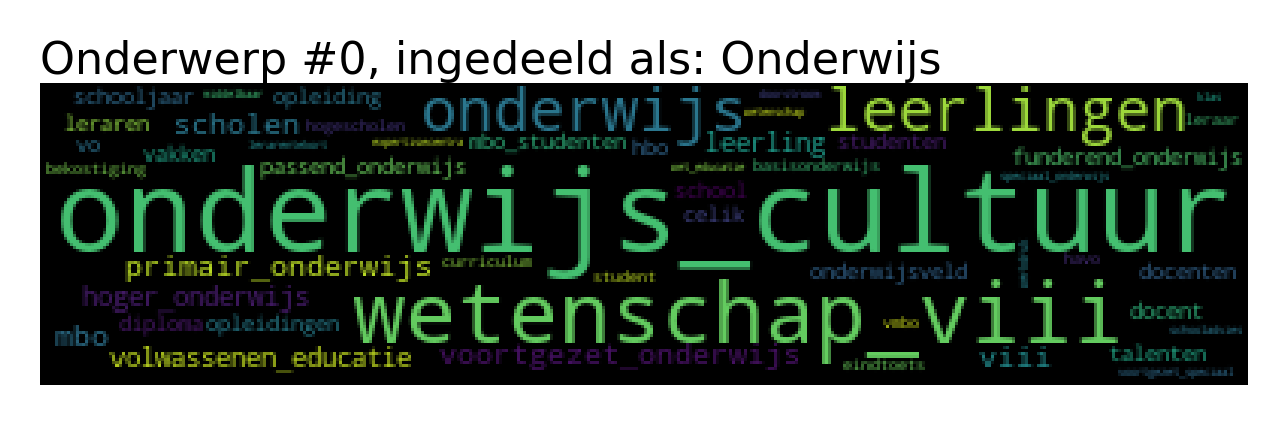

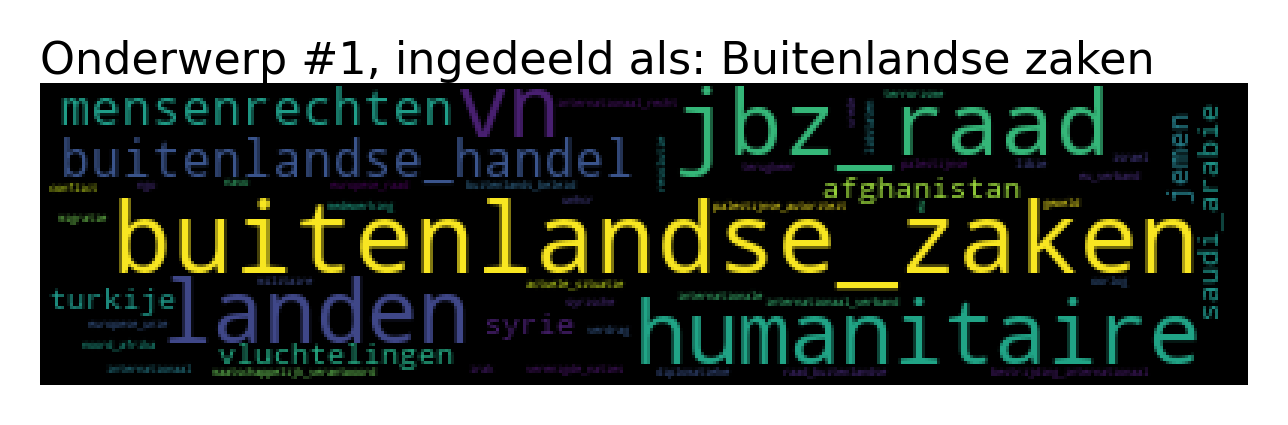

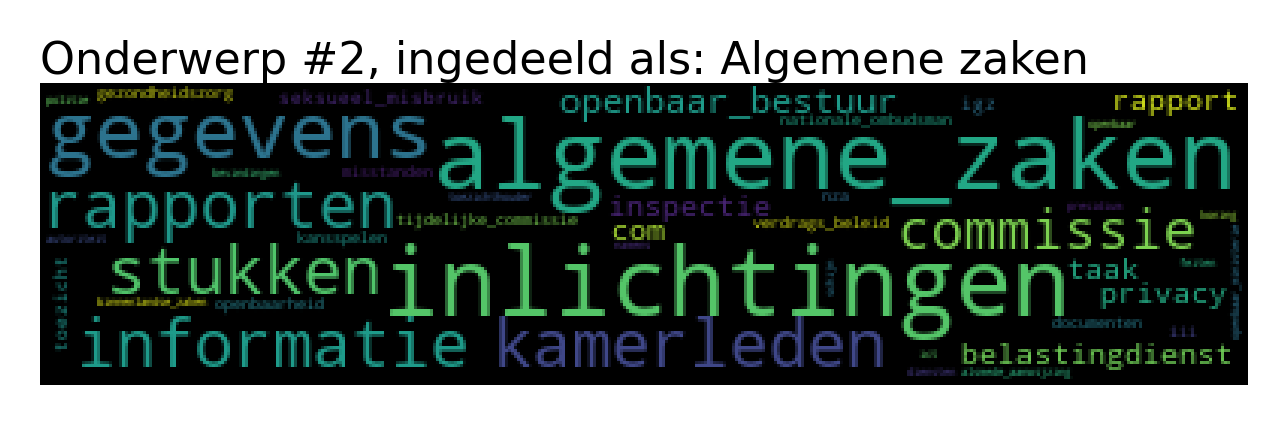

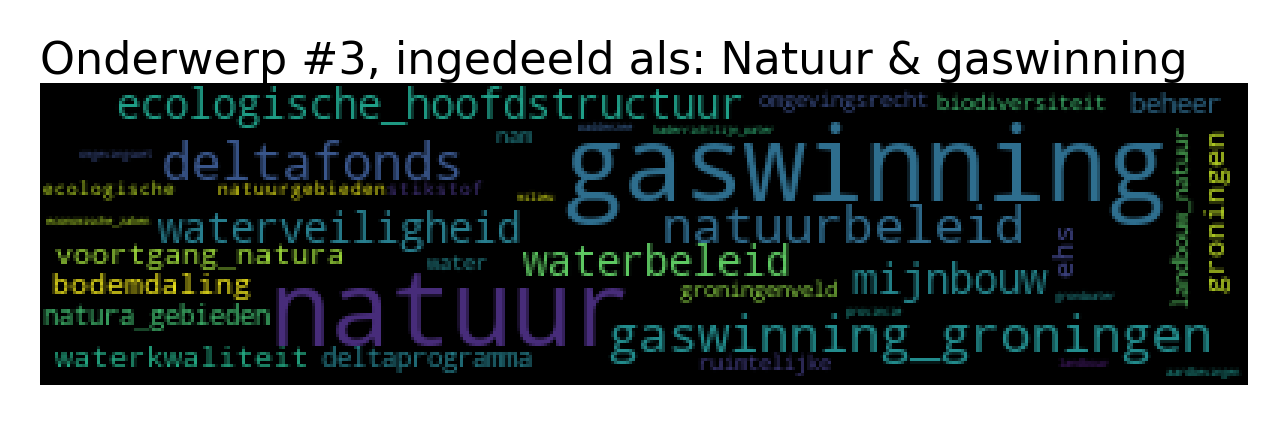

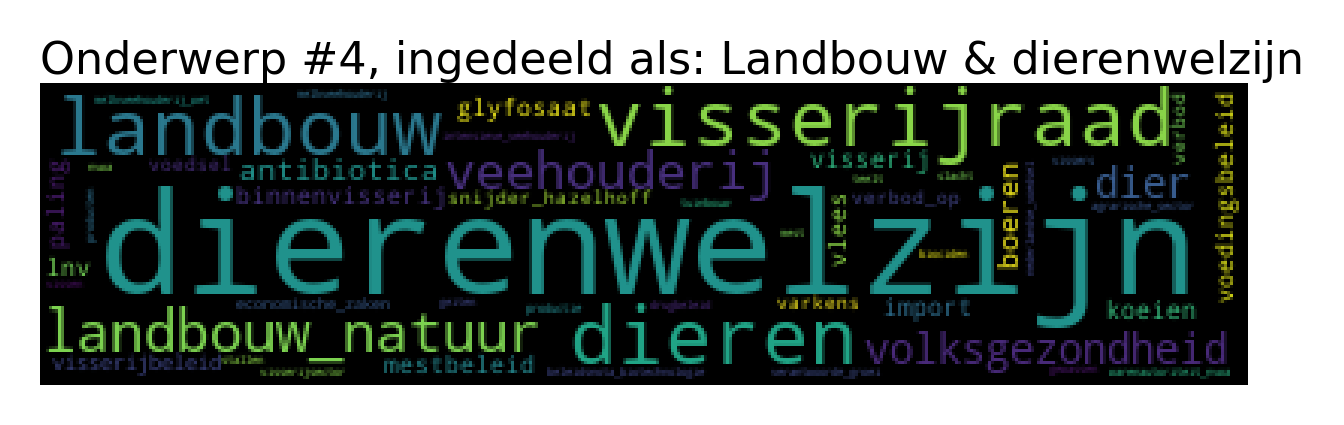

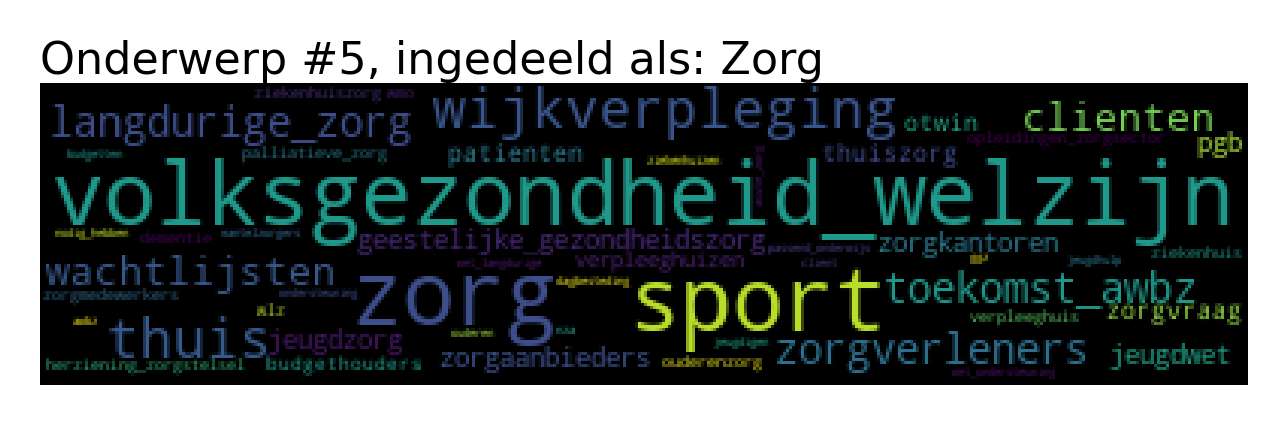

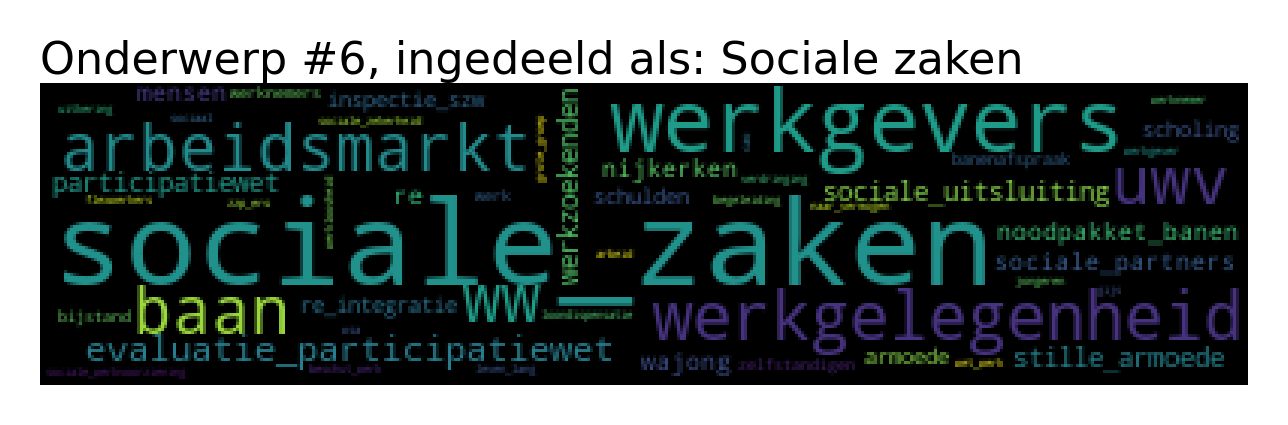

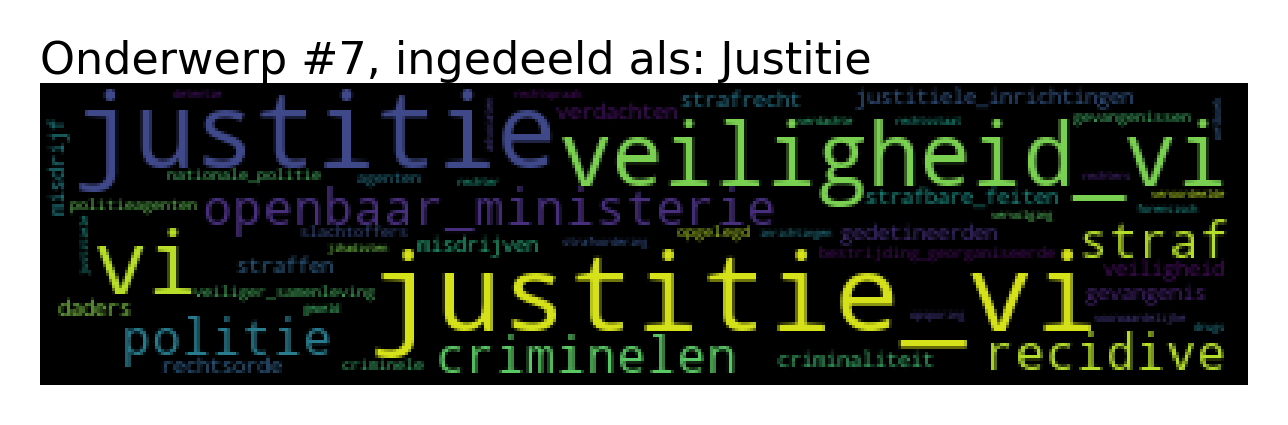

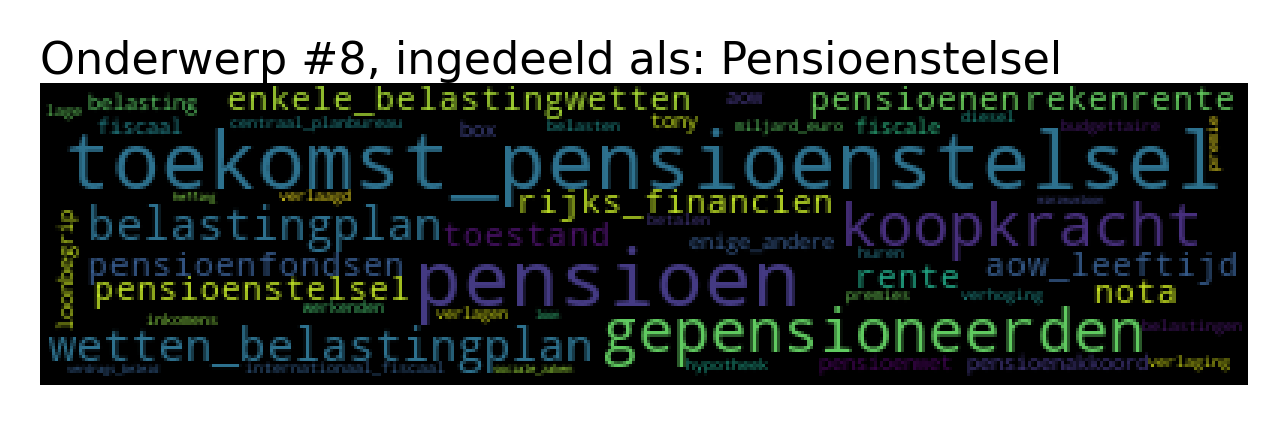

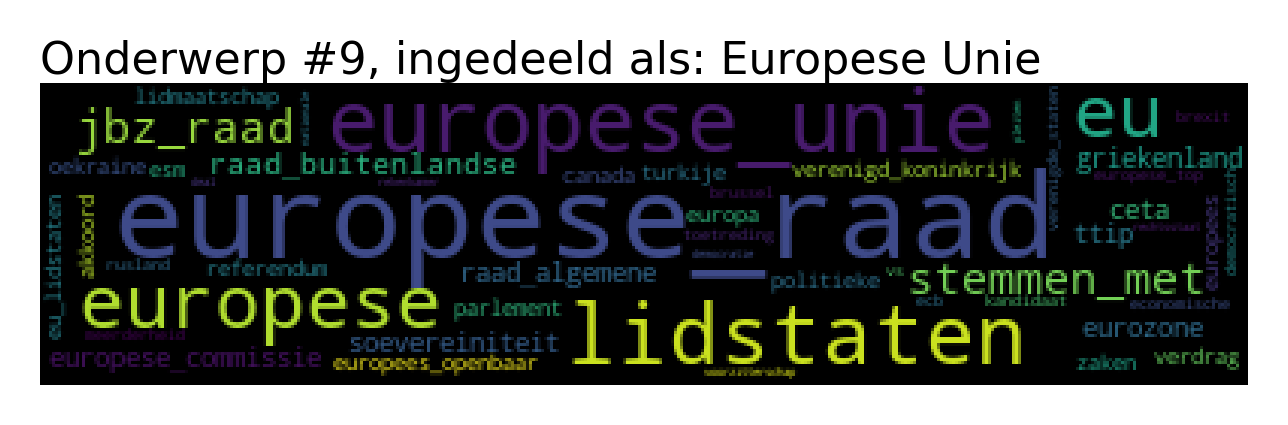

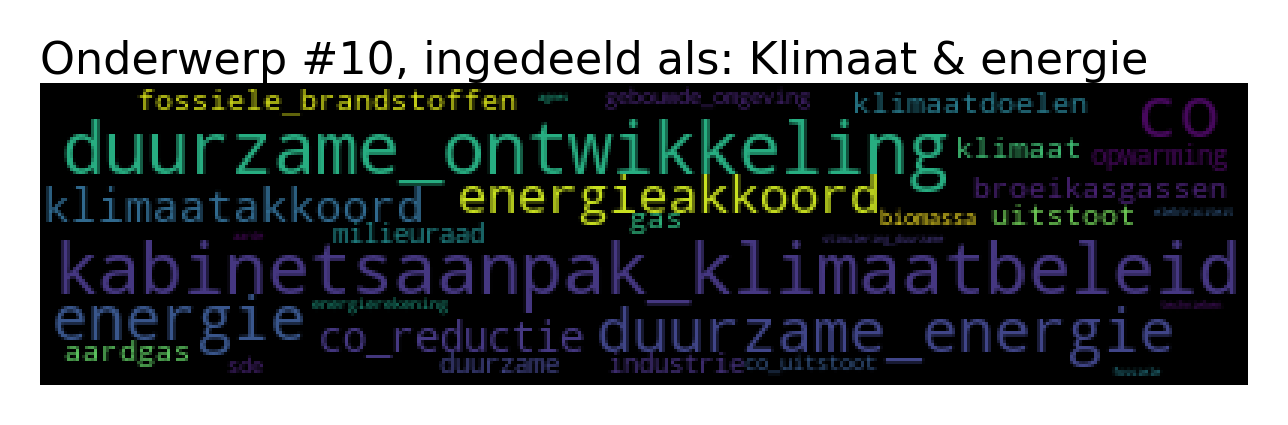

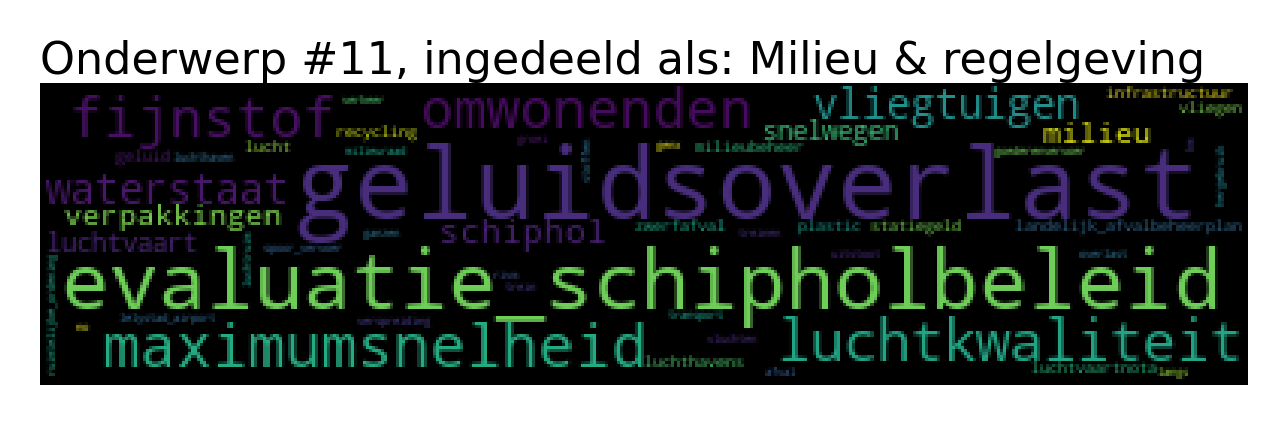

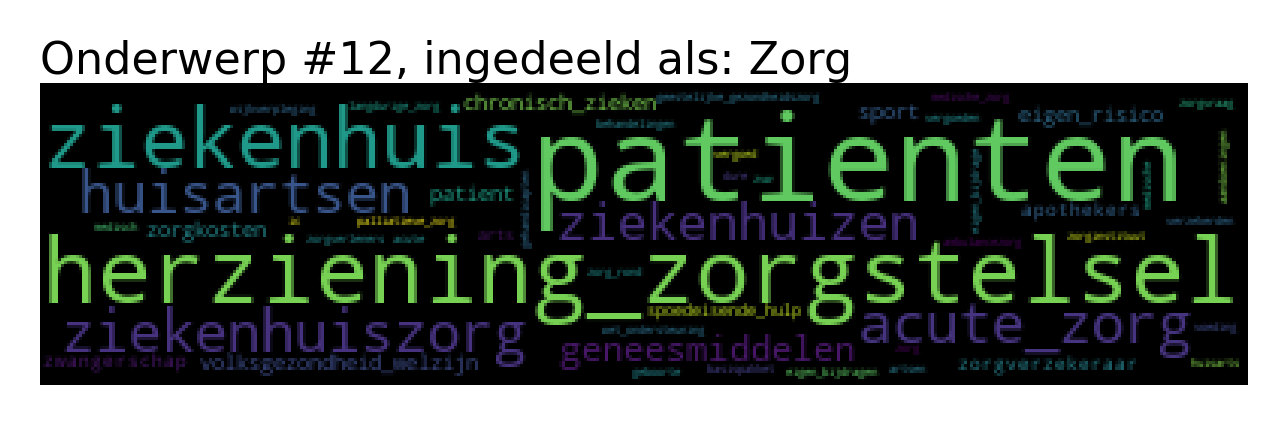

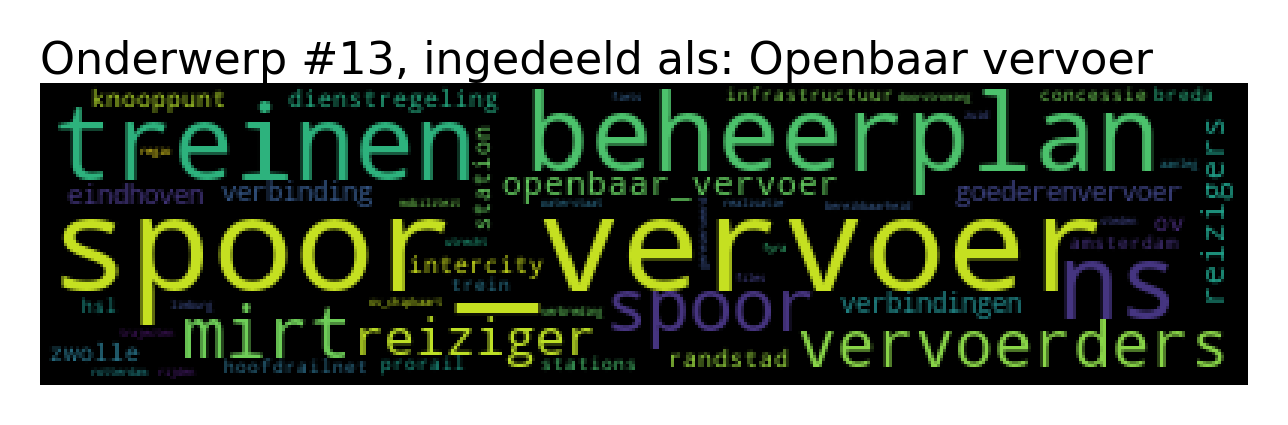

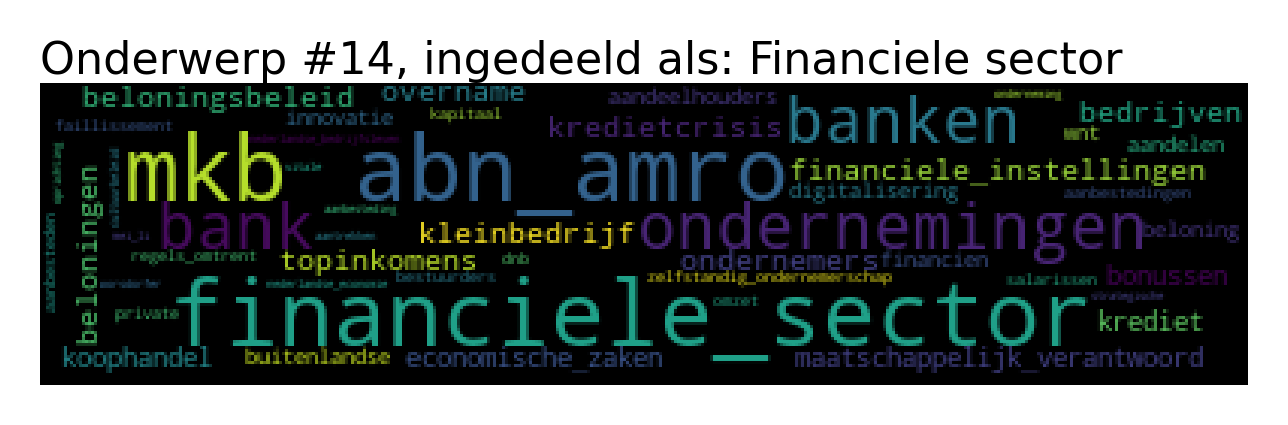

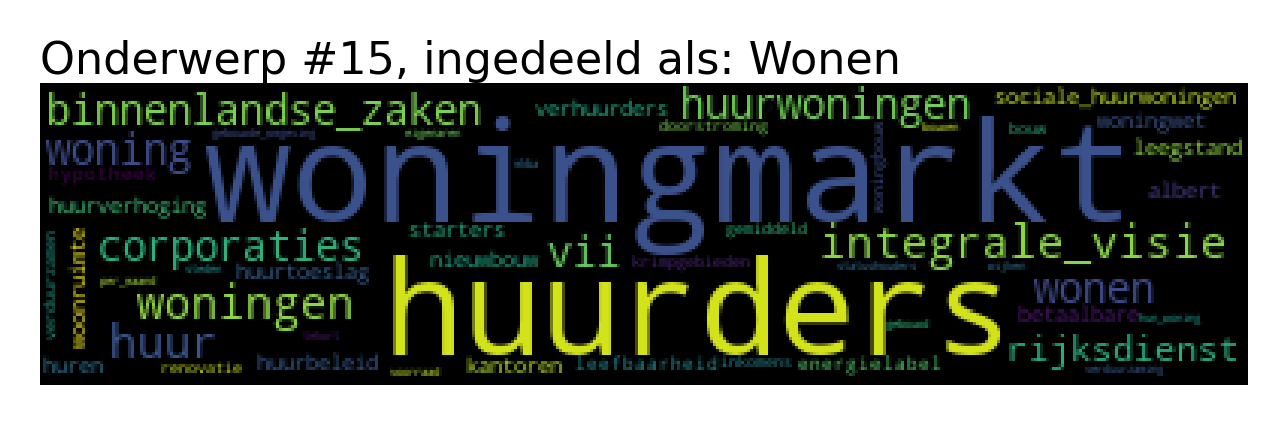

In [35]:
# hide_input

topics = {
  0: 'Onderwijs',  
  1: 'Buitenlandse zaken',  
  2: 'Algemene zaken',  
  3: 'Natuur & gaswinning',  
  4: 'Landbouw & dierenwelzijn',  
  5: 'Zorg',  
  6: 'Sociale zaken',  
  7: 'Justitie',  
  8: 'Pensioenstelsel',  
  9: 'Europese Unie',  
  10: 'Klimaat & energie',  
  11: 'Milieu & regelgeving',  
  12: 'Zorg',  
  13: 'Openbaar vervoer',  
  14: 'Financiele sector',  
  15: 'Wonen'
  }
for i, topic in enumerate(topic_words):
    # print(f'\nOnderwerp {i+1}, geclassificeerd als: {topics[i]}:\n{words}')
    model.generate_topic_wordcloud(model, topic_num = i, reduced=True, text = topics[i])